In [1]:
import pandas as pd
import json
import os
import matplotlib as mpl
from matplotlib import pyplot as plt
import requests
from io import StringIO as sio
from matplotlib.patches import Patch
import matplotlib.ticker as ticker
import itertools
import re
import sys
import pprint
import statistics
import numpy as np
import seaborn as sns
from datetime import datetime
from scipy.stats import fisher_exact
import math

module_dir = "./scripts/"
sys.path.append(module_dir)

import balticEdited as bt
# import reassortment_rates_host as rea
import reassortment_utils as rea

#use treesort_prepper to prep files and run treesort

#run before_plotting on treesort trees so then it is ready for plotting with baltic


In [2]:
def load_tree(path,filename,region_dict, host_dict):
    nwkPath=f"{path}/{filename}"
    mytree = bt.loadNewick(nwkPath, absoluteTime= False)
    mytree = traits(mytree, region_dict, host_dict)
    return(mytree)


def load_clock(blength_file):

    with open(blength_file) as f:
        data = json.load(f)

    rate = data["clock"]["rate"]
    year = data["clock"]["rtt_Tmrca"]
    
    return rate, year

def load_trait_data(traits_file):

    with open(traits_file) as f:
        data = json.load(f)
    
    region_dict = {}
    host_dict = {}

    for node_name, node_data in data['nodes'].items():
        region_dict[node_name] = node_data.get("region")
        host_dict[node_name] = node_data.get("host")

    return(region_dict, host_dict)

def traits(tree, region_dict, host_dict):
    
    for k in tree.Objects:
        if k.branchType == "node":
            k.traits["region"] = region_dict.get(k.traits["label"])
            k.traits["host"] = host_dict.get(k.traits["label"])
        if k.branchType == "leaf":
            k.traits["region"] = region_dict.get(k.name)
            k.traits["host"] = host_dict.get(k.name)
    return(tree)

In [3]:
ref = "ha"

clock_rate, root_yr = load_clock(f"./preprepped/branch-lengths_h3nx_{ref}.json")
tree_dict = {}

for i in range(1,6):
    
    path = f'trees_{i}'
    filename = 'for_plotting.nwk'
    region_dict, host_dict = load_trait_data(f"trees_{i}/traits_{i}/traits_h3nx_{ref}.json")
    mytree = load_tree(path, filename, region_dict, host_dict)
    
    tree_dict[f"trees_{i}"] = mytree


In [4]:
current_year = 2025
fit_time = 1

node_rea_counts = {name: {} for name in tree_dict.keys()}
leaf_rea_counts = {name: {} for name in tree_dict.keys()}

node_counts = {name: {} for name in tree_dict.keys()}
leaf_counts = {name: {} for name in tree_dict.keys()}

rea_fits = {name: {} for name in tree_dict.keys()}
clonal_fits = {name: {} for name in tree_dict.keys()}
rea_unfits = {name: {} for name in tree_dict.keys()}
clonal_unfits = {name: {} for name in tree_dict.keys()}


for name, tree in tree_dict.items():
    
    node_count = node_rea_count = leaf_count = leaf_rea_count= 0
    
    rea_fit = clonal_fit = rea_unfit = clonal_unfit = 0
    
    tree.traverse_tree()  
    tree.sortBranches()
    
    leaf_heights = {}

    for leaf in tree.getExternal():
        leaf_heights[leaf.name] = (leaf.height, leaf.name.split("|")[1])
        
    
    for k in tree.Objects:

        # for the fisher's exact test

        if k.is_leaf():

            leaf_count += 1

            if k.traits.get('is_reassorted'):

                leaf_rea_count += 1

        elif k.is_node():

            node_count += 1

            if k.traits.get('is_reassorted'):

                node_rea_count += 1

            # for the lineage fitness analysis
            
            # excluding nodes that are less than 2 years old 
            
            if (k.height / clock_rate) >= (current_year - root_yr) - fit_time:
                continue
                
            # which is correct? 
            
            # 1. find the leaf with the highest root to tip divergence (height) 
            # then subtract the current node's height from that leafs height
            
            # leaf_height = max(leaf_heights[leaf][0] for leaf in k.leaves)
            
            # 2. find the tip with the latest date and subtract the current node's height from that leafs height

            dates_and_heights = [(leaf_heights[leaf][1], leaf_heights[leaf][0]) for leaf in k.leaves]
                
            max_date, leaf_height = max(dates_and_heights, key=lambda x: x[0])
            
            date = (leaf_height - k.height) / clock_rate
            
            # date = int(max_date[:4]) - ((k.height / clock_rate) + root_yr)

            if date > fit_time:

                if k.traits.get('is_reassorted'):
                    rea_fit += 1

                else:
                    clonal_fit += 1     

            else:

                if k.traits.get('is_reassorted'):
                    rea_unfit += 1

                else:
                    clonal_unfit += 1
                  
    node_counts[name] = node_count
    leaf_counts[name] = leaf_count
    
    node_rea_counts[name] = node_rea_count
    leaf_rea_counts[name] = leaf_rea_count

    
    rea_fits[name] = rea_fit
    clonal_fits[name] = clonal_fit

    rea_unfits[name] = rea_unfit
    clonal_unfits[name] = clonal_unfit
    

In [5]:
print(rea_fits)
print(clonal_fits)

print(rea_unfits)
print(clonal_unfits)

{'trees_1': 482, 'trees_2': 482, 'trees_3': 448, 'trees_4': 470, 'trees_5': 474}
{'trees_1': 829, 'trees_2': 836, 'trees_3': 850, 'trees_4': 839, 'trees_5': 844}
{'trees_1': 433, 'trees_2': 439, 'trees_3': 417, 'trees_4': 435, 'trees_5': 408}
{'trees_1': 836, 'trees_2': 823, 'trees_3': 865, 'trees_4': 836, 'trees_5': 854}


In [6]:
# fitness analysis
p_values = []
odds_ratios = []
confidence = []

for name in tree_dict.keys():
    a = rea_fits[name]
    b = clonal_fits[name]
    c = rea_unfits[name]
    d = clonal_unfits[name]
    
    table = [[a, b], [c, d]]
    
    odds_ratio, p_value = fisher_exact(table, alternative='two-sided')
    
    if a > 0 and b > 0 and c > 0 and d > 0:
        se_log_or = math.sqrt(1/a + 1/b + 1/c + 1/d)
        log_or = math.log(odds_ratio)
        ci_low = math.exp(log_or - 1.96 * se_log_or)
        ci_high = math.exp(log_or + 1.96 * se_log_or)
    else:
        ci_low, ci_high = float('nan'), float('nan')
    
    odds_ratios.append(odds_ratio)
    p_values.append(p_value)
    confidence.append((ci_low, ci_high))

    print(f"{name}: p-value = {p_value:.6f}, odds ratio = {odds_ratio:.2f}, 95% CI = {ci_low, ci_high}")


trees_1: p-value = 0.161974, odds ratio = 1.12, 95% CI = (0.9551837022059448, 1.3192736060269818)
trees_2: p-value = 0.344892, odds ratio = 1.08, 95% CI = (0.9199618732678054, 1.2699374268166905)
trees_3: p-value = 0.297187, odds ratio = 1.09, 95% CI = (0.9283481402726717, 1.2875598031415898)
trees_4: p-value = 0.386292, odds ratio = 1.08, 95% CI = (0.9157660780151466, 1.265672321869738)
trees_5: p-value = 0.056145, odds ratio = 1.18, 95% CI = (0.9987155401117782, 1.3836472928097714)


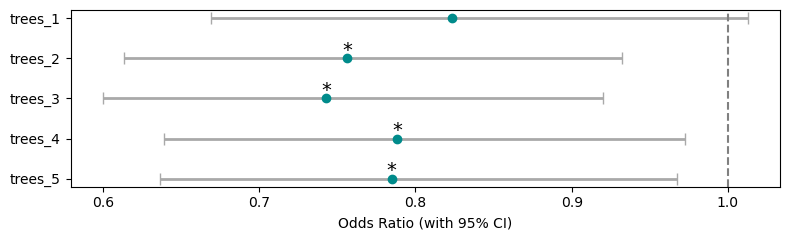

In [111]:
odds_ratios = np.array(odds_ratios)
p_values = np.array(p_values)
confidence = np.array(confidence)

ci_lowers = odds_ratios - confidence[:, 0]
ci_uppers = confidence[:, 1] - odds_ratios
error_bars = np.array([ci_lowers, ci_uppers])


tree_names = list(tree_dict.keys())
y_pos = np.arange(len(tree_names))


fig, ax = plt.subplots(figsize=(8, len(tree_names) * 0.5))


ax.errorbar(odds_ratios, y_pos, xerr=error_bars, fmt='o', color='darkcyan', 
            ecolor='darkgrey', elinewidth=2, capsize=4)

for i, (x, p) in enumerate(zip(odds_ratios, p_values)):
    if p < 0.05:
        ax.text(x, y_pos[i] - 0.20, '*', color='black', fontsize=14, va='center', ha='center')


ax.axvline(x=1, color='gray', linestyle='--')


ax.set_yticks(y_pos)
ax.set_yticklabels(tree_names)
ax.set_xlabel('Odds Ratio (with 95% CI)')
ax.invert_yaxis()  

plt.tight_layout()
plt.show()

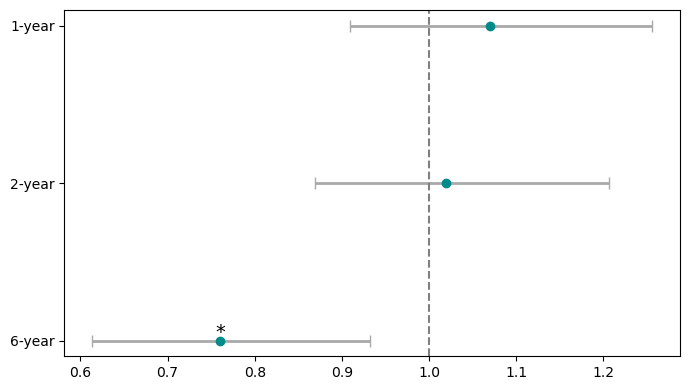

In [119]:
tree_2_results = {
    "1-year": {
        "p_value": 0.434889,
        "odds_ratio": 1.07,
        "95%_CI": (0.9098111036294729, 1.2558760608267894)
    },
    "2-year": {
        "p_value": 0.801683,
        "odds_ratio": 1.02,
        "95%_CI": (0.868801053229145, 1.20611223053116)
    },
    "6-year": {
        "p_value": 0.009467,
        "odds_ratio": 0.76,
        "95%_CI": (0.6135856468784917, 0.9324545499927205)
    }
}

tree_names = list(tree_2_results.keys())
odds_ratios = np.array([tree_2_results[tree]["odds_ratio"] for tree in tree_names])
p_values = np.array([tree_2_results[tree]["p_value"] for tree in tree_names])
ci_lowers = odds_ratios - np.array([tree_2_results[tree]["95%_CI"][0] for tree in tree_names])
ci_uppers = np.array([tree_2_results[tree]["95%_CI"][1] for tree in tree_names]) - odds_ratios
error_bars = np.array([ci_lowers, ci_uppers])

# Y positions
y_pos = np.arange(len(tree_names))

# Create the figure
fig, ax = plt.subplots(figsize=(7, 4))

# Plot odds ratios with error bars
ax.errorbar(odds_ratios, y_pos, xerr=error_bars, fmt='o', color='darkcyan', 
            ecolor='darkgrey', elinewidth=2, capsize=4)

# Annotate significant p-values
for i, (x, p) in enumerate(zip(odds_ratios, p_values)):
    if p < 0.05:
        ax.text(x, y_pos[i] - 0.05, '*', color='black', fontsize=14, va='center', ha='center')

# Add a vertical line at OR=1
ax.axvline(x=1, color='gray', linestyle='--')

# Set yticks and labels
ax.set_yticks(y_pos)
ax.set_yticklabels(tree_names)
ax.invert_yaxis()

plt.tight_layout()
plt.show()


In [232]:
print("# of leaves:")
print(leaf_counts)
print("# of reassorted leaves:")
print(leaf_rea_counts)
print("")
print("# of nodes:")
print(node_counts)
print("# of reassorted nodes:")
print(node_rea_counts)

# of leaves:
{'trees_1': 5261, 'trees_2': 5261, 'trees_3': 5261, 'trees_4': 5261, 'trees_5': 5261}
# of reassorted leaves:
{'trees_1': 1333, 'trees_2': 1328, 'trees_3': 1281, 'trees_4': 1310, 'trees_5': 1296}

# of nodes:
{'trees_1': 5260, 'trees_2': 5260, 'trees_3': 5260, 'trees_4': 5260, 'trees_5': 5260}
# of reassorted nodes:
{'trees_1': 1244, 'trees_2': 1252, 'trees_3': 1185, 'trees_4': 1237, 'trees_5': 1198}


In [79]:
# simple reassortments on leaves vs nodes
p_values = []
odds_ratios = []

for name in tree_dict.keys():
    a = node_rea_counts[name]
    b = node_counts[name] - node_rea_counts[name]
    c = leaf_rea_counts[name]
    d = leaf_counts[name] - leaf_rea_counts[name]
    
    table = [[a, b], [c, d]]
    
    odds_ratio, p_value = fisher_exact(table, alternative='two-sided')
    
    odds_ratios.append(odds_ratio)
    p_values.append(p_value)
    
    print(f"{name}: p-value = {p_value:.4f}, odds ratio = {odds_ratio:.2f}")


trees_1: p-value = 0.0460, odds ratio = 0.91
trees_2: p-value = 0.0892, odds ratio = 0.93
trees_3: p-value = 0.0288, odds ratio = 0.90
trees_4: p-value = 0.1013, odds ratio = 0.93
trees_5: p-value = 0.0262, odds ratio = 0.90


In [80]:
from scipy.stats import combine_pvalues

#from ai overview on google lol
log_or = np.log(odds_ratios)    
mean_log_or = np.mean(log_or)      
summary_or = np.exp(mean_log_or)   
print(f"combined odds ratio: {summary_or:.3f}")

#sci pi method
combined_stat, combined_p = combine_pvalues(p_values, method='fisher')
print(f"combined p-value: {combined_p:.4f}")

combined odds ratio: 0.914
combined p-value: 0.0009


In [7]:
# by host 

host_order = ['Avian', 'Canine','Swine', 'Human', 'Mink', 'Seal', 'Equine', 'Camel', 'Feline']
traitName = "host"
min_leaves = 10

subtree_hosts = {name: {} for name in tree_dict.keys()}

for name, mytree in tree_dict.items():
    
    mytree.root.traits[traitName]='ancestor' ## give root node some trait value that's different from what the actual tree root has, so it registers as a switch

    host_trees={host:[] for host in host_order}

    for k in sorted(mytree.Objects,key=lambda x:x.height):
        kp=k.parent     # kp is the parent node of k

        # get current node's (k) and its parent's (kp) trait states
        kloc=k.traits[traitName]   # kloc = trait of k; kc = trait of k; they are the same thing
        if traitName in k.parent.traits:  # if parent has a trait block, use that trait, else assign to ancestor
            kploc=kp.traits[traitName]     # kploc = trait of parental node
        else:
            kploc='ancestor'

        # print(k.traits)
        # print(f"kploc = {kploc}")
        # print(f"kloc = {kloc}") 

        # if states do not match
        if kloc!= "ancestor" and kloc != kploc:      # if node and parental node do not have the same trait
            #N_children=len(k.leaves)
            traverse_condition=lambda w:w.traits[traitName]==kloc     # traverse tree for all nodes whose traitname = kc
            # print('subtree resulting from '+kploc+' > '+kloc+' switch, traversing within '+ kloc)

            subtree=mytree.subtree(k,traverse_condition=traverse_condition) ## this function returns a new baltic object that contains a trait-traversed subtree, starting from node k, for as long as the traversal stays within the starting trait value state

            if subtree != None:
                clade_leaves = [leaf for leaf in subtree.getExternal() if leaf.traits[traitName] == kloc]
                if len(clade_leaves) >= min_leaves:
                    subtree.traverse_tree()
                    subtree.sortBranches()
                    host_trees[kloc].append((kploc,subtree))
                    
        subtree_hosts[name] = host_trees


In [15]:
host_order = ['Avian', 'Canine', 'Swine', 'Human', 'Equine']
current_year = 2025
fit_time = 10

nodes = {name: {} for name in tree_dict.keys()}
leaves = {name: {} for name in tree_dict.keys()}

nodes_rea = {name: {} for name in tree_dict.keys()}
leaves_rea = {name: {} for name in tree_dict.keys()}

rea_fits = {name: {} for name in tree_dict.keys()}
clonal_fits = {name: {} for name in tree_dict.keys()}

rea_unfits = {name: {} for name in tree_dict.keys()}
clonal_unfits = {name: {} for name in tree_dict.keys()}


for name, host_trees in subtree_hosts.items(): 
    
    host_rea_nodes = {host:int for host in host_order}
    host_rea_leaves = {host:int for host in host_order}
    
    host_nodes = {host:int for host in host_order}
    host_leaves = {host:int for host in host_order}
    
    host_rea_fits = {host:int for host in host_order}
    host_clonal_fits = {host:int for host in host_order}
    
    host_rea_unfits = {host:int for host in host_order}
    host_clonal_unfits = {host:int for host in host_order}
    
    for host, subtrees in host_trees.items():
        
        if host == "Seal" or host == "Camel" or host == "Feline" or host == "Mink":
            continue  
        
        node_count = node_rea_count = leaf_count = leaf_rea_count = 0
    
        rea_fit = clonal_fit = rea_unfit = clonal_unfit = 0
        

        for _, subtree in subtrees:
             
            if host == "Canine" and _ == "Equine":
                continue
                
            subtree.traverse_tree()  
            subtree.sortBranches()

            leaf_heights = {}

            for leaf in subtree.getExternal():
                leaf_heights[leaf.name] = (leaf.height, leaf.name.split("|")[1])
                
            for k in subtree.Objects:
                
                if k.is_leaf():

                    leaf_count += 1

                    if k.traits.get('is_reassorted'):

                        leaf_rea_count += 1
                
                
                elif k.is_node():

                    node_count += 1

                    if k.traits.get('is_reassorted'):

                        node_rea_count += 1
                        
                    if (k.height / clock_rate) >= (current_year - root_yr) - fit_time:
                        continue
                
                    dates_and_heights = [(leaf_heights[leaf][1], leaf_heights[leaf][0]) for leaf in k.leaves]
                
                    max_date, leaf_height = max(dates_and_heights, key=lambda x: x[0])

                    date = (leaf_height - k.height) / clock_rate
                    
                    
                    if date > fit_time:

                        if k.traits.get('is_reassorted'):
                            rea_fit += 1

                        else:
                            clonal_fit += 1     

                    else:

                        if k.traits.get('is_reassorted'):
                            rea_unfit += 1

                        else:
                            clonal_unfit += 1
        
        host_nodes[host] = node_count
        host_leaves[host] = leaf_count
        
        host_rea_nodes[host] = node_rea_count
        host_rea_leaves[host] = leaf_rea_count
        
        host_rea_fits[host] = rea_fit
        host_clonal_fits[host] = clonal_fit
        
        host_rea_unfits[host] = rea_unfit
        host_clonal_unfits[host] = clonal_unfit

        
        
    nodes[name] = host_nodes
    leaves[name] = host_leaves
    
    nodes_rea[name] = host_rea_nodes
    leaves_rea[name] = host_rea_leaves
    
    rea_fits[name] = host_rea_fits
    clonal_fits[name] = host_clonal_fits
    
    rea_unfits[name] = host_rea_unfits
    clonal_unfits[name] = host_clonal_unfits
    
                    

In [16]:
fit_analysis_host_results = {}

for tree in tree_dict.keys():
    
    fit_analysis_host_results[tree] = {}
    
    for host in host_order:
        
        A = rea_fits[tree][host]
        B = clonal_fits[tree][host]
        C = rea_unfits[tree][host]
        D = clonal_unfits[tree][host]
        
        contingency = [[A, B],
                       [C, D]]

        odds_ratio, p_value = fisher_exact(contingency, alternative='two-sided')
        
        
        if A > 0 and B > 0 and C > 0 and D > 0:
            se_log_or = math.sqrt(1/A + 1/B + 1/C + 1/D)
            log_or = math.log(odds_ratio)
            ci_low = math.exp(log_or - 1.96 * se_log_or)
            ci_high = math.exp(log_or + 1.96 * se_log_or)
        else:
            ci_low, ci_high = float('nan'), float('nan')

        fit_analysis_host_results[tree][host] = {
            'odds_ratio': odds_ratio,
            'p_value': p_value,
            '95%_CI': (ci_low, ci_high),
            'contingency_table': contingency
        }
        

pprint.pprint(fit_analysis_host_results)


{'trees_1': {'Avian': {'95%_CI': (0.5926061111997208, 1.073036687406952),
                       'contingency_table': [[77, 130], [771, 1038]],
                       'odds_ratio': 0.7974259203831189,
                       'p_value': 0.13788510839887863},
             'Canine': {'95%_CI': (0.21033041824880933, 15.567774002903146),
                        'contingency_table': [[1, 28], [6, 304]],
                        'odds_ratio': 1.8095238095238095,
                        'p_value': 0.46840237673282215},
             'Equine': {'95%_CI': (nan, nan),
                        'contingency_table': [[0, 52], [11, 163]],
                        'odds_ratio': 0.0,
                        'p_value': 0.07253559194474653},
             'Human': {'95%_CI': (0.30127261954004975, 3.041617920030282),
                       'contingency_table': [[4, 63], [13, 196]],
                       'odds_ratio': 0.9572649572649573,
                       'p_value': 1.0},
             'Swine': {'95%_CI': (

In [155]:
leaves_nodes_host_results = {}

for tree in tree_dict.keys():
    
    leaves_nodes_host_results[tree] = {}
    
    for host in host_order:
        
        A = leaves_rea[tree][host]
        B = leaves[tree][host] - leaves_rea[tree][host]
        C = nodes_rea[tree][host]
        D = nodes[tree][host] - nodes_rea[tree][host]

        contingency = [[A, B],
                       [C, D]]

        odds_ratio, p_value = fisher_exact(contingency, alternative='two-sided')
        leaves_nodes_host_results[tree][host] = {
            'odds_ratio': odds_ratio,
            'p_value': p_value,
            'contingency_table': contingency
        }

pprint.pprint(leaves_nodes_host_results)


{'trees_1': {'Avian': {'contingency_table': [[1007, 1307], [944, 1383]],
                       'odds_ratio': 1.1287663882873187,
                       'p_value': 0.04317536082455528},
             'Canine': {'contingency_table': [[15, 317], [7, 332]],
                        'odds_ratio': 2.2442541685443893,
                        'p_value': 0.08502381622536971},
             'Equine': {'contingency_table': [[9, 215], [11, 215]],
                        'odds_ratio': 0.8181818181818182,
                        'p_value': 0.819793656481691},
             'Human': {'contingency_table': [[12, 223], [17, 259]],
                       'odds_ratio': 0.8198364547612768,
                       'p_value': 0.7026923226899295},
             'Swine': {'contingency_table': [[259, 1680], [243, 1702]],
                       'odds_ratio': 1.07980109739369,
                       'p_value': 0.44415376535819084}},
 'trees_2': {'Avian': {'contingency_table': [[995, 1319], [953, 1374]],
              

NameError: name 'leaves_nodes_host_results' is not defined

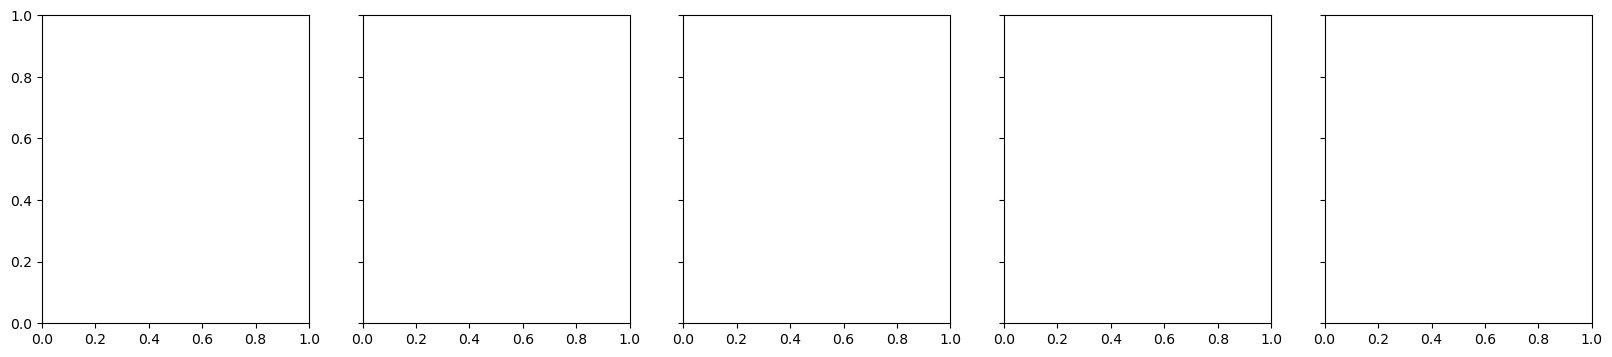

In [12]:
fig, axs = plt.subplots(1, 5, figsize=(20, 4), sharey=True)

for i, host in enumerate(host_order):
    odds = [leaves_nodes_host_results[tree][host]['odds_ratio'] for tree in tree_dict.keys()]
    pvals = [leaves_nodes_host_results[tree][host]['p_value'] for tree in tree_dict.keys()]
    
    ax = axs[i]
    ax.bar(range(5), odds, color='skyblue', edgecolor='black')
    ax.axhline(1, color='red', linestyle='--', linewidth=1)
    
    for j, (y, p) in enumerate(zip(odds, pvals)):
        if p < 0.05:
            ax.text(j, y + 0.05, "*", ha='center', va='bottom', fontsize=14, color='black')
    
    ax.set_title(host)
    ax.set_xticks(range(5))
    ax.set_xticklabels([t for t in range(5)])
    if i == 0:
        ax.set_ylabel("Odds Ratio")
    ax.set_xlabel("Replicates")
    
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


0.00020755017095353334
0.002689993142894893
0.0028486888657848547
0.0007807173346784787
0.0003197109989229893
2.793171878630463e-06
4.72680232964688e-06
3.3990984823001745e-06
1.962847595974499e-06
0.004516435754035548


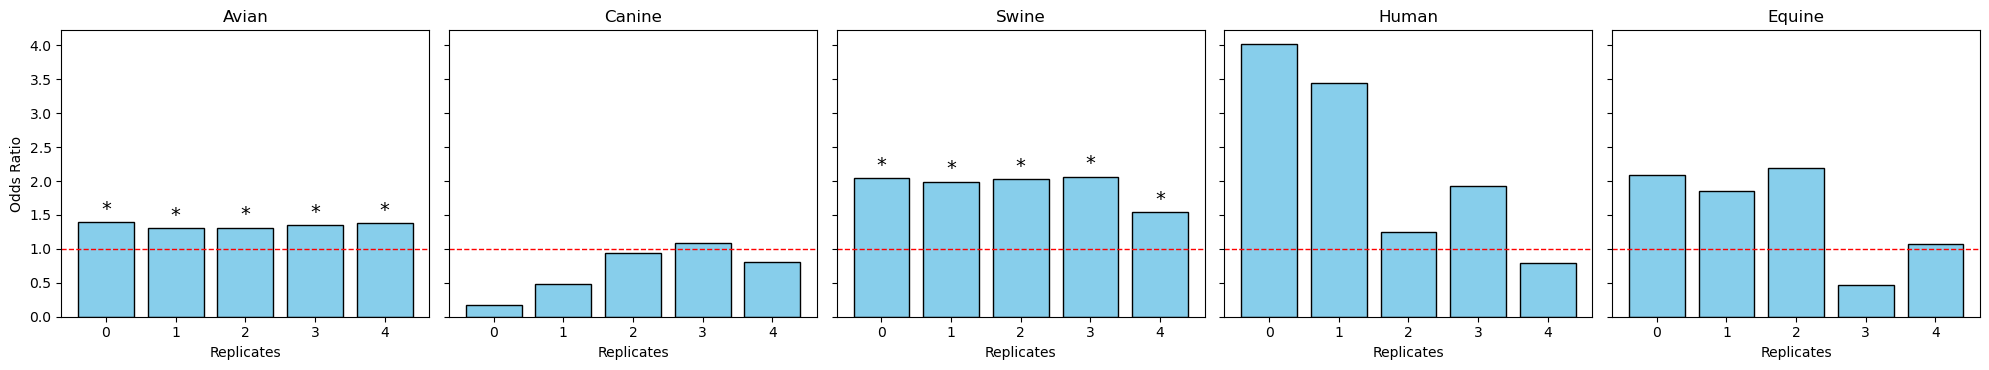

In [13]:
fig, axs = plt.subplots(1, 5, figsize=(20, 4), sharey=True)

for i, host in enumerate(host_order):
    odds = [fit_analysis_host_results[tree][host]['odds_ratio'] for tree in tree_dict.keys()]
    pvals = [fit_analysis_host_results[tree][host]['p_value'] for tree in tree_dict.keys()]
    
    ax = axs[i]
    ax.bar(range(5), odds, color='skyblue', edgecolor='black')
    ax.axhline(1, color='red', linestyle='--', linewidth=1)
    
    for j, (y, p) in enumerate(zip(odds, pvals)):
        if p < 0.05:
            print(p)
            ax.text(j, y + 0.05, "*", ha='center', va='bottom', fontsize=14, color='black')
    
    ax.set_title(host)
    ax.set_xticks(range(5))
    # ax.set_xticklabels([t.split('_')[1] for t in host_trees])
    if i == 0:
        ax.set_ylabel("Odds Ratio")
    ax.set_xlabel("Replicates")
    
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


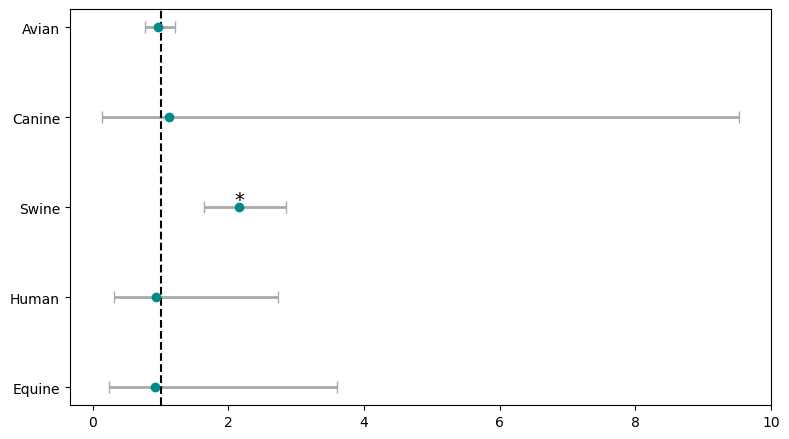

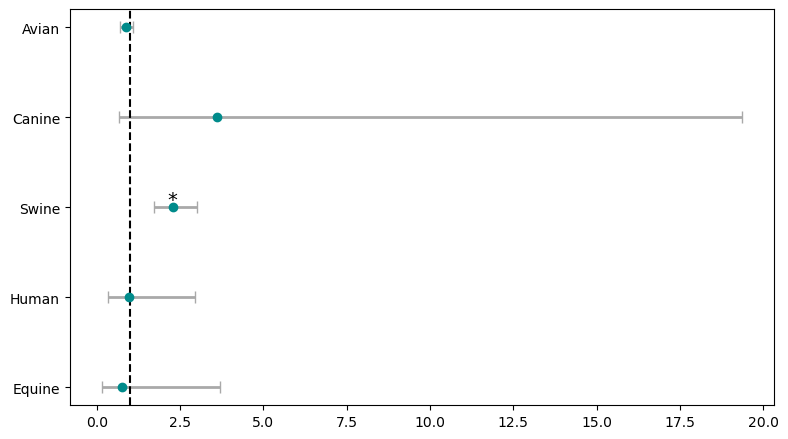

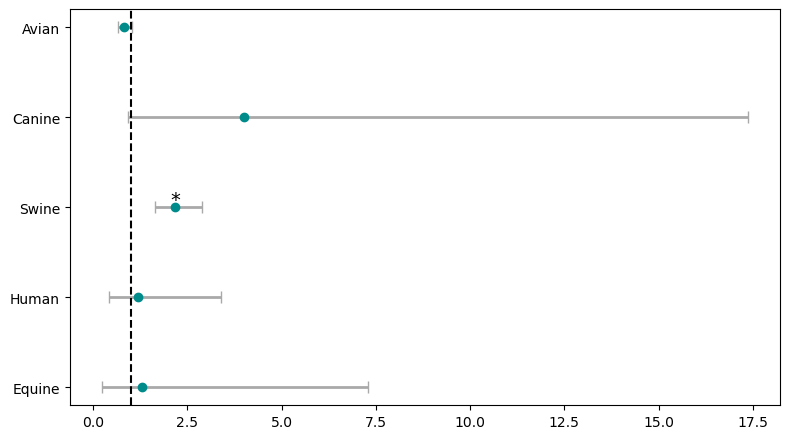

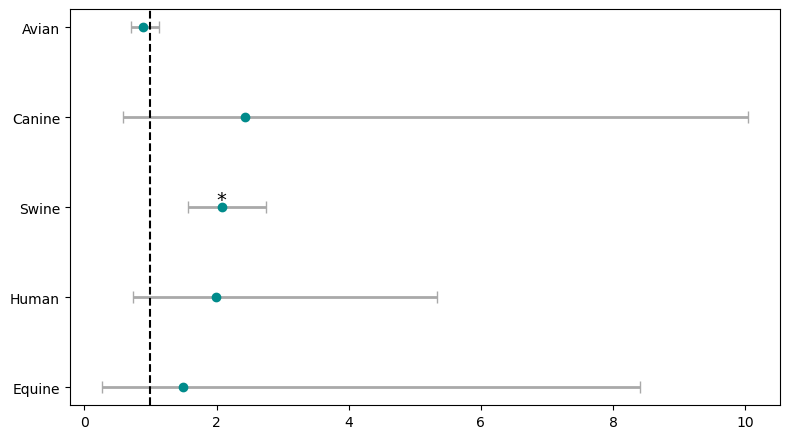

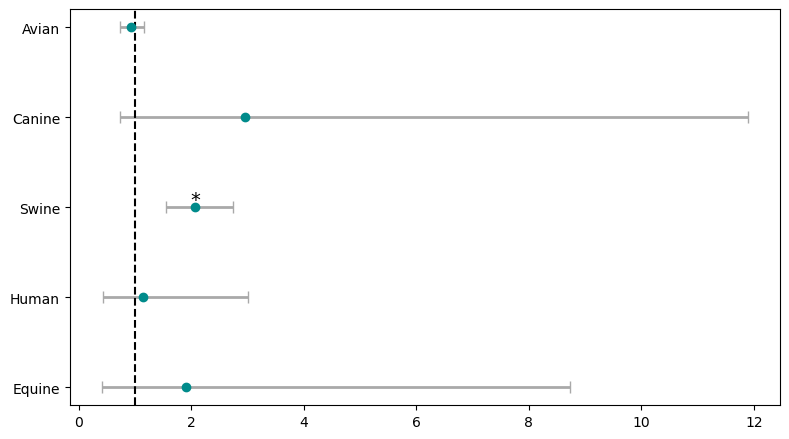

In [158]:
for tree_name, hosts_data in fit_analysis_host_results.items():

    host_names = list(hosts_data.keys())

    odds_ratios = np.array([hosts_data[host]['odds_ratio'] for host in host_names])
    p_values = np.array([hosts_data[host]['p_value'] for host in host_names])
    ci_lowers = odds_ratios - np.array([hosts_data[host]['95%_CI'][0] for host in host_names])
    ci_uppers = np.array([hosts_data[host]['95%_CI'][1] for host in host_names]) - odds_ratios
    error_bars = np.array([ci_lowers, ci_uppers])

    y_pos = np.arange(len(host_names))


    fig, ax = plt.subplots(figsize=(8, len(host_names) * 0.9))


    ax.errorbar(odds_ratios, y_pos, xerr=error_bars, fmt='o', color='darkcyan',
                ecolor='darkgrey', elinewidth=2, capsize=4)

    for i, (x, p) in enumerate(zip(odds_ratios, p_values)):
        if p < 0.05:
            ax.text(x, y_pos[i] - 0.08, '*', color='black', fontsize=14, va='center', ha='center')


    ax.axvline(x=1, color='black', linestyle='--')

    ax.set_yticks(y_pos)
    ax.set_yticklabels(host_names)
    ax.invert_yaxis() 
    plt.tight_layout()
    plt.show()


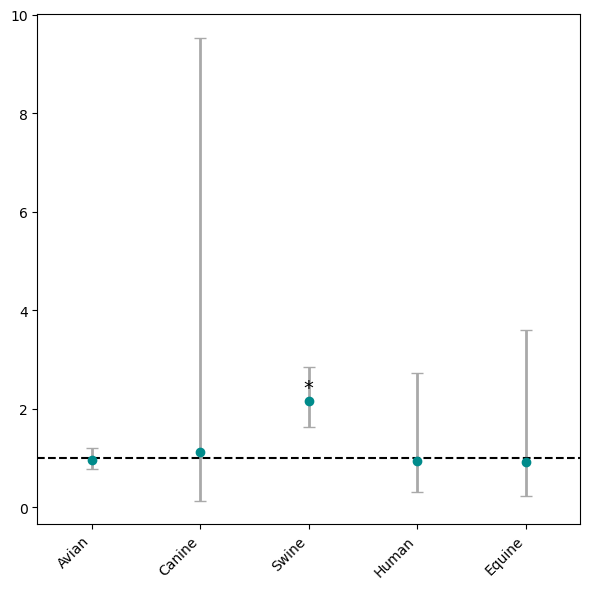

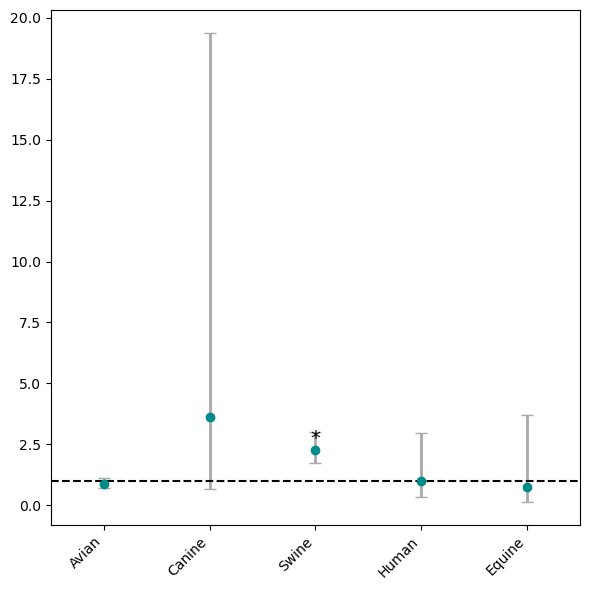

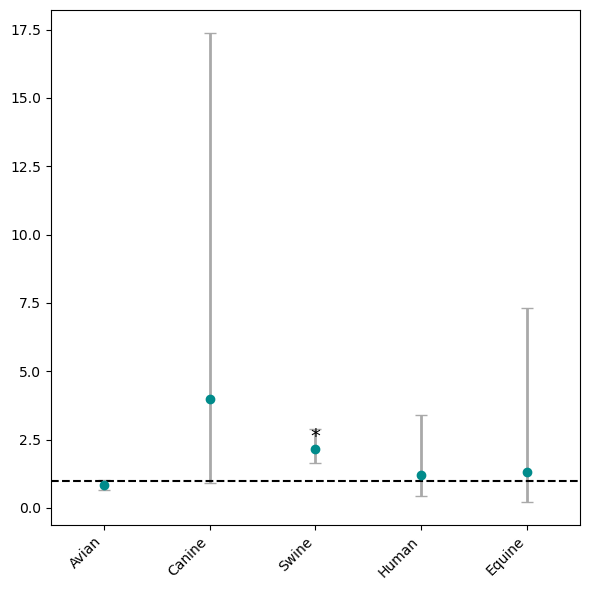

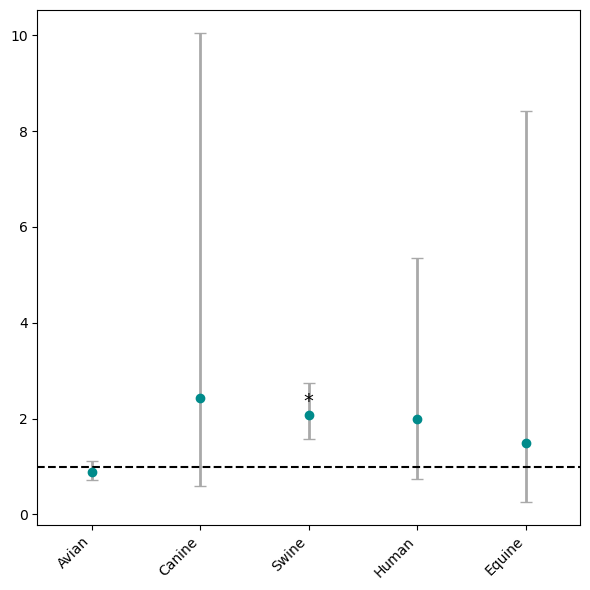

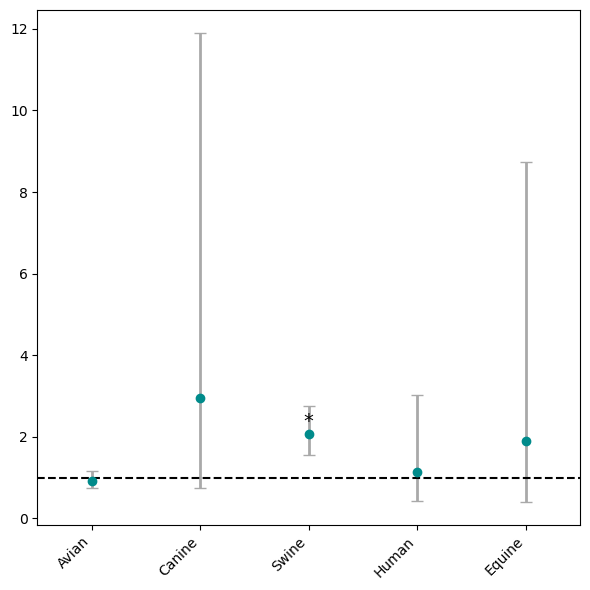

In [192]:
for tree_name, hosts_data in fit_analysis_host_results.items():

    host_names = list(hosts_data.keys())

    odds_ratios = np.array([hosts_data[host]['odds_ratio'] for host in host_names])
    p_values = np.array([hosts_data[host]['p_value'] for host in host_names])
    ci_lowers = odds_ratios - np.array([hosts_data[host]['95%_CI'][0] for host in host_names])
    ci_uppers = np.array([hosts_data[host]['95%_CI'][1] for host in host_names]) - odds_ratios
    error_bars = np.array([ci_lowers, ci_uppers])

    x_pos = np.arange(len(host_names))  # Now x corresponds to host names

    fig, ax = plt.subplots(figsize=(len(host_names) * 1.2, 6))

    # Plot vertical error bars now (error in y-direction)
    ax.errorbar(x_pos, odds_ratios, yerr=error_bars, fmt='o', color='darkcyan',
                ecolor='darkgrey', elinewidth=2, capsize=4)

    # Add significance stars
    for i, (y, p) in enumerate(zip(odds_ratios, p_values)):
        if p < 0.05:
            ax.text(x_pos[i], y + 0.08, '*', color='black', fontsize=14, va='bottom', ha='center')

    # Horizontal line at y=1
    ax.axhline(y=1, color='black', linestyle='--')

    # Set x-axis with host names
    ax.set_xticks(x_pos)
    ax.set_xticklabels(host_names, rotation=45, ha='right')  # rotated for readability
    ax.set_xlim(-0.5, len(host_names) - 0.5)

    plt.tight_layout()
    plt.show()


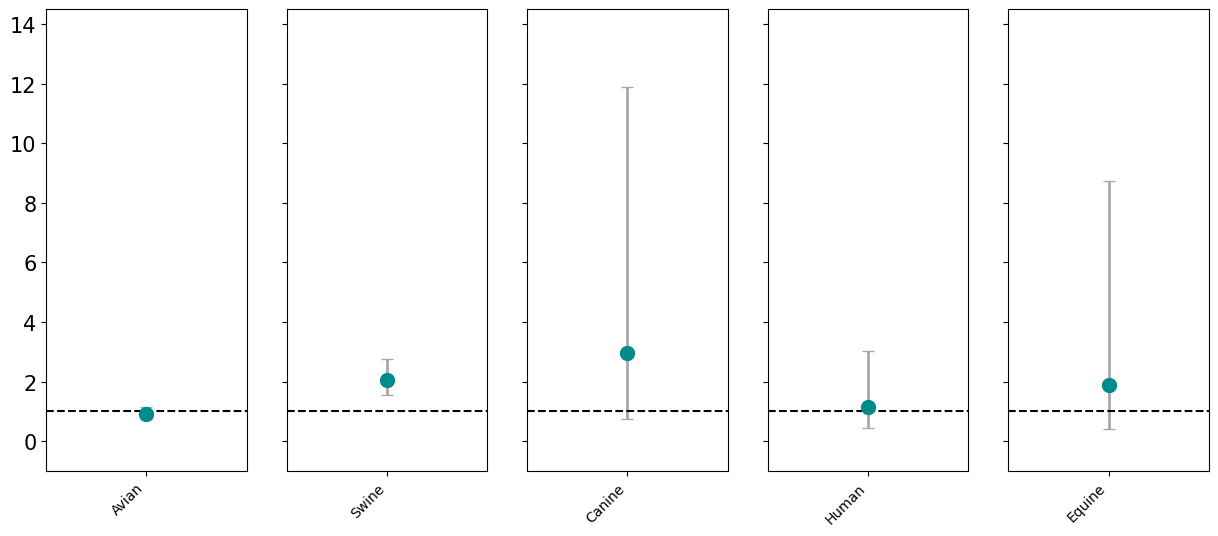

In [193]:
priority_hosts = ['Avian', 'Swine']
host_list = priority_hosts + [h for h in hosts_data if h not in priority_hosts]
num_hosts = len(host_list)

fig, axes = plt.subplots(1, num_hosts, figsize=(num_hosts * 3, 6), sharey=True)

for ax, host in zip(axes, host_list):
    odds_ratio = hosts_data[host]['odds_ratio']
    p_value = hosts_data[host]['p_value']
    ci_lower, ci_upper = hosts_data[host]['95%_CI']

    ci_lower_error = odds_ratio - ci_lower
    ci_upper_error = ci_upper - odds_ratio
    error_bars = [[ci_lower_error], [ci_upper_error]]

    ax.errorbar([0], [odds_ratio], yerr=error_bars, fmt='o', color='darkcyan',
                ecolor='darkgrey', elinewidth=2, capsize=4, markersize=10)

    # if p_value < 0.05:
    #     ax.text(0.15, odds_ratio, '*', color='black', fontsize=14, va='center', ha='left')

    ax.axhline(y=1, color='black', linestyle='--')
    ax.set_xticks([0])
    ax.set_xticklabels([host], rotation=45, ha='right')
    ax.tick_params(axis='y', labelsize=15)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 14.5)

